Chest X-Ray Diagnostics using Deep Learning Techniques
------------------------------------------------------

<img src="gradcam.jpg" width="40%">

### Project Objectives

* Pre-process and prepare a real-world X-ray dataset, checking for data leakage
* Implement a weighted loss function to address class imbalance.
* Use transfer learning to retrain a DenseNet model for X-ray image classification
* Measure diagnostic performance by computing the AUC (Area Under the Curve) for the ROC (Receiver Operating Characteristic) curve
* Visualize model activity using GradCAMs

### Key Tasks

* Data exploration
    * Data types and null values check
    * Unique IDs check
    * Explore data labels
    * Investigate a single image
    * Pixel distribution
* Data preprocessing
    * Standardization
    * Class imbalance
        * Counting labels - class distribution
        * Weighted loss function - single and multi-class
    * Data leakage
        * Patient overlap
        * Data correction
* Model
    * Densenet
    * Leveraging pre-trained models using transfer learning
* Evaluation
    * AUC and ROC curves
* Model Visualization
    * GradCAM

### Import Packages

In [59]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import util
import eval_metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

### Dataset

The dataset used here is the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. The dataset can be downloaded from [here](https://nihcc.app.box.com/v/ChestXray-NIHCC)

Each image in the dataset contains multiple labels identifying 14 different pathological conditions which can in turn be used by physicials to diagnose 8 different diseases. This objective here is use this dataset to develop a model that will provide binary classification predictions for each of the 14 pathologies

The csv files represent a small sample of this dataset. 
1. nih/train-small.csv: 875 images 
2. nih/valid-small.csv: 109 images 
3. nih/test.csv: 420 images

#### Read the data

In [103]:
train_df = pd.read_csv("nih/train-small.csv")
valid_df = pd.read_csv("nih/valid-small.csv")
test_df = pd.read_csv("nih/test.csv")
# labels order matters here. Set messes the order up. So results vary with each run
#labels = list(set(test_df.columns) - set(['Image','PatientId']))
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']
for colname in labels:
    train_df[colname] = train_df[colname].astype(np.float32) 
    valid_df[colname] = valid_df[colname].astype(np.float32) 
    test_df[colname] = test_df[colname].astype(np.float32) 
    
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the training dataframe')
print(f'There are {valid_df.shape[0]} rows and {valid_df.shape[1]} columns in the validation dataframe')
print(f'There are {test_df.shape[0]} rows and {test_df.shape[1]} columns in the validation dataframe')

There are 1000 rows and 16 columns in the training dataframe
There are 200 rows and 16 columns in the validation dataframe
There are 420 rows and 16 columns in the validation dataframe


In [3]:
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8270,0.0,0.0,0.0
1,00029855_001.png,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,29855,0.0,0.0,0.0
2,00001297_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1297,1.0,0.0,0.0
3,00012359_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12359,0.0,0.0,0.0
4,00017951_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,17951,0.0,0.0,0.0


### Patient Overlap and Data Leakage

Patient overlap in medical data is a part of a more general problem in machine learning called data leakage. In this case leakage occurs when a patient has taken multiple X-ray images at different points of time and they get split between the datasets. In other words, training data leaks into the validation set. One way to prevent this is to do the dataset split on the patient level. Here, the overlap between the training and the validation set is identified and the common entries are removed from the training set

In [22]:
ids_train_set = set(train_df['PatientId'].values)
ids_valid_set = set(valid_df['PatientId'].values)
patient_overlap = list(ids_train_set.intersection(ids_valid_set))
n_overlap = len(patient_overlap)
print(f'There are {len(ids_train_set)} unique Patient IDs in the training set')
print(f'There are {len(ids_valid_set)} unique Patient IDs in the validation set')
print(f'\nThere are {n_overlap} Patient IDs common to the training and validation sets\nDropping common entities')

train_overlap_idxs = []
valid_overlap_idxs = []
for idx in range(n_overlap):
    train_overlap_idxs.extend(train_df.index[train_df['PatientId'] == patient_overlap[idx]])
    valid_overlap_idxs.extend(valid_df.index[valid_df['PatientId'] == patient_overlap[idx]])
    
# print(f'These are the indices of overlapping patients in the training set: ')
# print(f'{train_overlap_idxs}')
# print(f'These are the indices of overlapping patients in the validation set: ')
# print(f'{valid_overlap_idxs}')

# Drop the overlapping rows from the validation set
train_df.drop(train_overlap_idxs, inplace=True)
ids_train_set = set(train_df['PatientId'].values)

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_valid_set))
n_overlap = len(patient_overlap)
print(f'\nAfter dropping, there are {n_overlap} Patient IDs common to the training and validation sets')

There are 731 unique Patient IDs in the training set
There are 199 unique Patient IDs in the validation set

There are 0 Patient IDs common to the training and validation sets
Dropping common entities

After dropping, there are 0 Patient IDs common to the training and validation sets


### Image Generators

The ImageDataGenerator class from the Keras framework is used here to build the "generator"
* This class provides support for basic data augmentation such as random horizontal flipping of images.
* This generator will also be used to transform the values in each batch so that their mean is zero and their standard deviation is 1. This will facilitate model training by standardizing the input distribution.
* The generator also converts the single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.This is required because the pre-trained model that we'll use requires three-channel inputs.

In [23]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """
    
    print("getting train generator...")

    # normalize images - mean and std.dev
    # samplewise: per-image
    # featurewise: across entire training dataset (needs to be used with fit())
    image_generator = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
    
    # flow from directory with specified batch size and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

**A different generator is required for the validation and training data because:**
* The generator normalizes each image using batch statistics
* For validation and test data, this should not be done since in reality, these images are processed one at a time rather than batches. Knowing the batch statistics in advance would give the model an advantage

In [24]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    # the whole training data could be used as well instead of a sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [25]:
IMAGE_DIR = "nih/images-small/"
# should labels be different (order) for train, test and valid?
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 770 validated image filenames.
getting train and valid generators...
Found 770 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


**Verify mean and std.dev**

In [26]:
print("Mean of a training image: ",train_generator.next()[0][0].mean())
print("Std.dev of a training image: ",train_generator.next()[0][0].std())

print("Mean of a test image: ",test_generator.next()[0][0].mean())
print("Std.dev of a test image: ",test_generator.next()[0][0].std())

Mean of a training image:  2.5431316e-08
Std.dev of a training image:  1.0
Mean of a test image:  0.025114244
Std.dev of a test image:  1.0316594


**Sample image provided by the generator**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


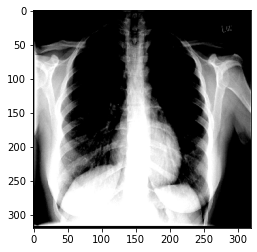

In [27]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

### Class Imbalance

#### Class Frequencies

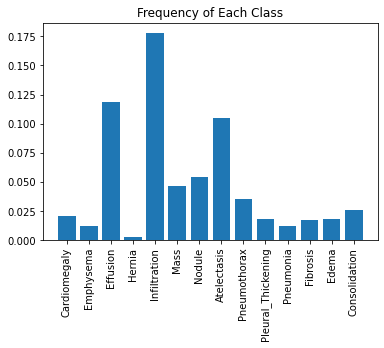

In [28]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

It can be seen from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.)

* The Hernia pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%.
* Even the Infiltration pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, the model should be trained using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss.

If a normal cross-entropy loss function is used with a highly unbalanced dataset, then the algorithm will be incentivized to prioritize the majority class, since it contributes more to the loss.

$$
\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).
$$

The formulation above yields a loss function that is dominated by the negative class

pos freqs: [0.02077922 0.01168831 0.11818182 0.0025974  0.17792208 0.04675325
 0.05454545 0.10519481 0.03506494 0.01818182 0.01168831 0.01688312
 0.01818182 0.02597403]
neg freqs: [0.9792208  0.9883117  0.8818182  0.9974026  0.82207793 0.9532468
 0.94545454 0.8948052  0.96493506 0.9818182  0.9883117  0.98311687
 0.9818182  0.97402596]


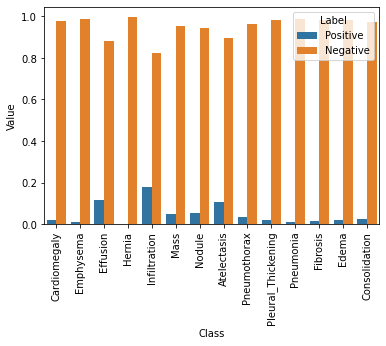

In [29]:
N = train_generator.labels.shape[0]
freq_pos = np.sum(train_generator.labels, axis = 0) / N
freq_neg = 1 - freq_pos
print(f"pos freqs: {freq_pos}")
print(f"neg freqs: {freq_neg}")

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. One way to make the contributions equal is by multiplying each example from each class by a class-specific weight factor.

$$
w_{pos} \times freq_{p} = w_{neg} \times freq_{n},
$$

Where,
$$
w_{pos} = freq_{neg}
$$
$$
w_{neg} = freq_{pos}
$$

This way, the contribution of the positive and negative labels to the loss will be balanced

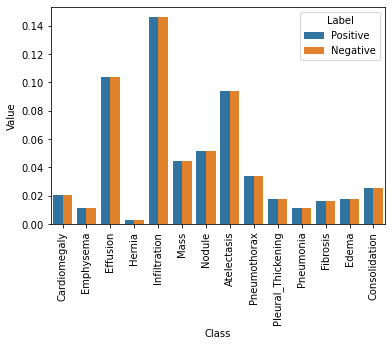

In [30]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

#### Weighted Loss

The loss function after taking into account the weighting factors is given by

$$
\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).
$$

In [31]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        loss = 0.0
        for i in range(len(pos_weights)):
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) 
        return loss
    return weighted_loss

### Model: DenseNet121

The model used here will be a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model loaded directly from the Keras library. Two layers are added on to this
1. A GlobalAveragePooling2D layer to get the average of the last convolution layers from DenseNet121.
2. A Dense layer with sigmoid activation to get the prediction logits for each of our classes.

The loss function used is the custom weighted loss function described previously

In [32]:
base_model = DenseNet121(weights='./nih/densenet.hdf5', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [33]:
# history = model.fit_generator(train_generator, 
#                               validation_data=valid_generator,
#                               steps_per_epoch=100, 
#                               validation_steps=25, 
#                               epochs = 3)

# plt.plot(history.history['loss'])
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("Training Loss Curve")
# plt.show()

# load weights and make predictions
model.load_weights("./nih/pretrained_model.h5")
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

### Performance Evaluation

The following metrics are used to evaluate the performance of the model
* AUROC (Area Under the Curve from the Receiver Operating Characteristics)
* Sensitivity
* Specificity
* Positive Predictive Value
* Negative Predictive Value

In [82]:
def true_positives(y, pred, th=0.5):
    TP = 0
    thresholded_preds = pred >= th
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    return TP

def true_negatives(y, pred, th=0.5):
    TN = 0
    thresholded_preds = pred >= th
    TN = np.sum((y == 0 ) & (thresholded_preds == 0 ))
    return TN

def false_positives(y, pred, th=0.5):
    FP = 0
    thresholded_preds = pred >= th
    FP = np.sum((y == 0) & (thresholded_preds == 1))
    return FP

def false_negatives(y, pred, th=0.5):
    FN = 0
    thresholded_preds = pred >= th
    FN = np.sum((y == 1) & (thresholded_preds == 0))
    return FN

def get_accuracy(y, pred, th=0.5):
    accuracy = 0.0
    TP = true_positives(y, pred, th)   
    FP = false_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y,pred, th)
    accuracy = (TP + TN) / ( TP + FP + TN + FN)
    return accuracy

def get_prevalence(y):
    prevalence = 0.0
    prevalence = np.mean(y)    
    return prevalence

def get_sensitivity(y, pred, th=0.5):
    sensitivity = 0.0
    TP = true_positives(y,pred, th)
    FN = false_negatives(y, pred, th)
    sensitivity = TP / (TP + FN)
    return sensitivity

def get_specificity(y, pred, th=0.5):
    TN = true_negatives(y,pred, th)
    FP = false_positives(y, pred, th)
    specificity = TN / (TN + FP)   
    return specificity

def get_ppv(y, pred, th=0.5):
    PPV = 0.0
    TP = true_positives(y,pred,th)
    FP = false_positives(y,pred,th)
    PPV = TP / (TP + FP)    
    return PPV

def get_npv(y, pred, th=0.5):
    NPV = 0.0
    TN = true_negatives(y,pred,th)
    FN = false_negatives(y,pred,th)
    NPV = TN / (TN + FN)    
    return NPV

In [105]:
y = test_df.drop(['Image','PatientId'], axis=1).values
eval_metrics.get_performance_metrics(y, predicted_vals, labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,39,308,62,11,0.826,0.119,0.78,0.832,0.386,0.966,0.896,0.517,0.5
Emphysema,33,285,79,23,0.757,0.133,0.589,0.783,0.295,0.925,0.796,0.393,0.5
Effusion,39,249,118,14,0.686,0.126,0.736,0.678,0.248,0.947,0.763,0.371,0.5
Hernia,33,261,109,17,0.7,0.119,0.66,0.705,0.232,0.939,0.773,0.344,0.5
Infiltration,38,215,146,21,0.602,0.14,0.644,0.596,0.207,0.911,0.65,0.313,0.5
Mass,45,276,84,15,0.764,0.143,0.75,0.767,0.349,0.948,0.819,0.476,0.5
Nodule,32,245,121,22,0.66,0.129,0.593,0.669,0.209,0.918,0.655,0.309,0.5
Atelectasis,44,238,122,16,0.671,0.143,0.733,0.661,0.265,0.937,0.786,0.389,0.5
Pneumothorax,41,254,111,14,0.702,0.131,0.745,0.696,0.27,0.948,0.804,0.396,0.5


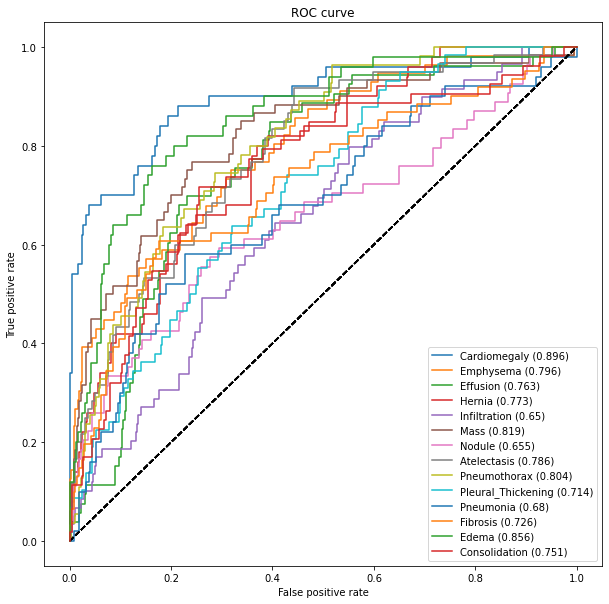

In [106]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

For reference, the AUC values from the ChexNeXt paper for both the model as well as radiologists are shown below:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="60%">

This method does take advantage of a few other tricks such as self-training and ensembling as well, which can give a significant boost to the performance.

For details about the best performing methods and their performance on this dataset, we encourage you to read the following papers:
- [CheXNet](https://arxiv.org/abs/1711.05225)
- [CheXpert](https://arxiv.org/pdf/1901.07031.pdf)
- [ChexNeXt](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002686)

### Visualize Learning with GradCAM

One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models).

One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM).

Class activation maps are useful for understanding where the model is "looking" when classifying an image.
In this section the GradCAM technique is used to produce a heatmap highlighting the important regions in the image for predicting the pathological condition.

This is done by extracting the gradients of each predicted class flowing into the model's final convolutional layer. 

It is worth mentioning that GradCAM does not provide a full explanation of the reasoning for each classification probability. However, it is still a useful tool for "debugging" our model and augmenting our prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.

Four classes with the highest performing AUC measures are looked into here

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


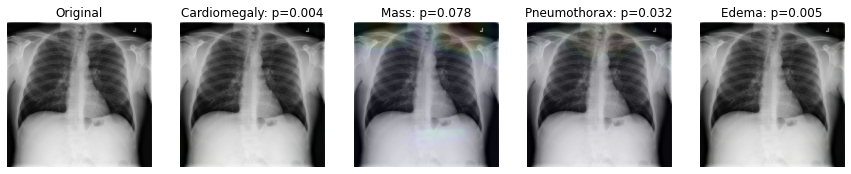

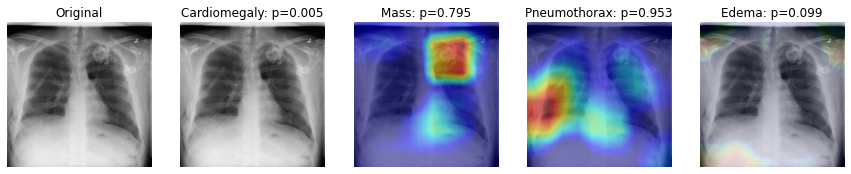

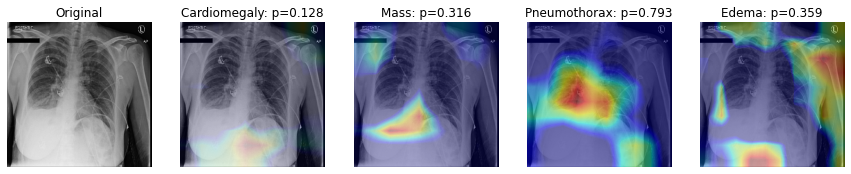

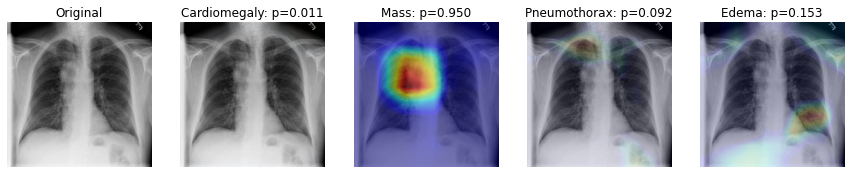

In [20]:
%load_ext autoreload
%autoreload 2
df = pd.read_csv("nih/train-small.csv")
IMAGE_DIR = "nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)